### Data and Acquisition

In [24]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import requests
import json
import pprint
import scipy as sc
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
from scipy.stats import norm
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# creating full urls from base and tails that do not appear in html of main page (allows us to avoid clicking through to sub-urls)
hunt_code = []
short_url = 'https://dwrapps.utah.gov/huntboundary/HaNumber'
hunt_nums = list(range(3000,3129))  #hard code list of limited entry hunt numbers
for each in hunt_nums:
    string = str(each)   # change each hunt number int to str for concatenation purposes
    letters = '?hn=EB' + string   # concatenate hunt letter abbreviations with hunt numbers to create full hunt code
    hunt_code.append(short_url + letters)

# creating empty lists of parameters of interests for later population
hunt_number = []
hunt_type = []
species = []
unit_name = []
weapon_type = []
season_dates = []
percent_harvest = []
pop_obj = []
current_pop = []
age_obj = []
current_age = []

# extracting data from urls
for i in hunt_code:
    res = requests.get(i)
    hunt = json.loads(res.text) 

    ### huntBios key
    res.headers['content-type']
    pagedata = res.content.decode("utf-8")
    hunt_num_json = json.loads(pagedata)
    huntBios = hunt_num_json['huntBios'][0]
    man_obj = huntBios['MANAGEMENT_OBJ']
    split = man_obj.split('~') # relevant information is contained in string; splitting string to useable elements
    # creating perent_harvest, pop_obj, current_pop, age_obj, current_age lists by splitting string correctly
    percent_harvest.append(split[0])
    pop_obj.append(split[1])
    current_pop.append(split[2])
    age_obj.append(split[5])
    current_age.append(split[6])
    

    ### huntMaster key
    # creating unit_name, hunt_number_hunt_type, species, and weapon_type lists from huntMaster key
    huntMaster = hunt_num_json['huntMaster']
    unit_name.append(huntMaster['HUNT_NAME'])
    hunt_number.append(huntMaster['HUNT_NBR'])
    hunt_type.append(huntMaster['HUNT_TYPE'])
    species.append(huntMaster['SPECIES'])
    weapon_type.append(huntMaster['WEAPON'])


    ### huntYears key
    # creating season_dates list from the huntYears key
    huntYears = hunt_num_json['huntYears']
    huntYears0 = (huntYears[0])
    szn = huntYears0['SEASON_DATE_TEXT']
    season_dates.append(szn)

# creating dataframe from lists created in last step
df=pd.DataFrame()
df['Unit Name']=unit_name
df['Hunt Number']=hunt_number
df['Type']=hunt_type
df['Species']=species
df['Season Dates']=season_dates
df['Weapon']=weapon_type
df['% Harvest Success']=percent_harvest
df['Pop Objective']=pop_obj
df['Current Pop']=current_pop
df['Age Objective']=age_obj
df['Current Age']=current_age

# print(unit_name)
# print(hunt_number)
# print(hunt_type)
# print(species)
# print(weapon_type)
# print(percent_harvest)
# print(pop_obj)
# print(current_pop)
# print(age_obj)
# print(current_age)
# print(season_dates)

### Cleaning

In [25]:
df.head(20)
print(type(df['Pop Objective'][18]))
print(df['Pop Objective'][18])

df.to_excel('check1.xlsx')
#manually cleaning
# Organize the data by unit name or population estimates. 
#We need to clean the wasatch range data, and then and populations that have a XXX-XXX format.I just take an average to the two
#values. I recommend delete the index column as well. 
#127 is missing a current age value. I copied it from other hunts in the same region. 


#fd is seperate from df. This means we wont have to scrape everytime we want to adjust the code.

<class 'str'>
5000-5900


In [26]:
fd = pd.read_excel(r'check.xlsx', index=False)
#fd.head()

#automatic data cleaning

for j in range(0,len(fd)):
    
    #first, get rid of any characters in the population data set (e.i. 1700 (Entire Beaver unit))
    fd['Pop Objective'][j]= ''.join(i for i in fd['Pop Objective'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    fd['Pop Objective'][j] = float(fd['Pop Objective'][j])
    fd['Current Pop'][j]= ''.join(i for i in fd['Current Pop'][j] if i.isdigit())
    #join to (an empty string) the variable i for every i in (any given variable) if i is a digit
    
    #get rid of the ranges of data (i.e. 1200-1500)
    #instead we take the average value of the range (1200-1500 ----> 1350)
    fd['Current Pop'][j] = float(fd['Current Pop'][j])
    q = fd['Age Objective'][j]
    q = q.split('–')
    #idk what that is, but its not a minus sign
    q[0] = float(q[0])
    q[1] = float(q[1])
    fd['Age Objective'][j] = sum(q)/len(q)

#set the relevant groups to float dtype from objective dtype    
fd[['Pop Objective','Current Pop','Age Objective','Current Age']]=fd[['Pop Objective','Current Pop','Age Objective','Current Age']].astype(float)
fd.head(20)




C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A val

,Unit Name,Hunt Number,Type,Species,Season Dates,Weapon,% Harvest Success,Pop Objective,Current Pop,Age Objective,Current Age
0,"Beaver, East",EB3000,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,57.1,1050.0,1450.0,7.75,7.5
1,"Book Cliffs, Bitter Creek/South",EB3001,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,39.5,7500.0,6300.0,6.75,7.2
2,"Book Cliffs, Little Creek Roadless",EB3002,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,44.4,7500.0,6300.0,7.75,7.3
3,"Cache, Meadowville",EB3003,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,18.2,2300.0,2300.0,4.75,4.8
4,"Cache, North",EB3004,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,33.3,2300.0,2300.0,4.75,4.3
5,"Cache, South",EB3005,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,15.4,2300.0,2300.0,6.75,5.1
6,"Central Mtns, Manti",EB3006,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,37.6,12000.0,11300.0,5.75,6.1
7,"Central Mtns, Nebo",EB3007,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,46.2,1450.0,2100.0,6.75,5.7
8,"Fillmore, Pahvant",EB3008,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,41.7,1600.0,1500.0,7.75,7.9
9,"La Sal, La Sal Mtns",EB3009,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,41.9,2500.0,2600.0,5.75,6.2


### Initial Data Exploration

In [27]:
# descriptive statistics on all the numerical elk data
fd.describe()

,% Harvest Success,Pop Objective,Current Pop,Age Objective,Current Age
count,129.000000,129.000000,129.000000,129.000000,129.000000
mean,70.489922,2848.062016,2646.899225,6.362403,6.279070
std,25.303464,3048.877733,2686.722285,1.017887,1.024441
min,0.000000,140.000000,200.000000,4.750000,4.300000
25%,55.600000,1050.000000,1100.000000,5.750000,5.500000
50%,75.000000,1600.000000,1500.000000,6.750000,6.200000
75%,91.700000,2500.000000,2600.000000,6.750000,7.200000
max,100.000000,12000.000000,11300.000000,7.750000,7.900000


In [28]:
# initial correlation study on numerical data
check = fd[['Hunt Number','% Harvest Success','Pop Objective','Current Pop','Age Objective','Current Age']]
check[['Pop Objective','Current Pop','Age Objective','Current Age']]=check[['Pop Objective','Current Pop','Age Objective','Current Age']].astype(float)
check.corr()


C:\Users\charl\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,% Harvest Success,Pop Objective,Current Pop,Age Objective,Current Age
% Harvest Success,1.000000,-0.012462,-0.007076,0.150782,0.310422
Pop Objective,-0.012462,1.000000,0.992617,-0.094621,0.107762
Current Pop,-0.007076,0.992617,1.000000,-0.106284,0.082660
Age Objective,0.150782,-0.094621,-0.106284,1.000000,0.761597
Current Age,0.310422,0.107762,0.082660,0.761597,1.000000


In [29]:
# sorting data based on number of animals, animal age and % success. if large, trophy bulls are the objective, these 3 categories are important hunt data
fd.sort_values(['Current Pop', 'Current Age', '% Harvest Success'], ascending=[False, False, False])

,Unit Name,Hunt Number,Type,Species,Season Dates,Weapon,% Harvest Success,Pop Objective,Current Pop,Age Objective,Current Age
108,"Central Mtns, Manti",EB3108,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,100.0,12000.0,11300.0,5.75,6.1
126,"Central Mtns, Manti",EB3126,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,84.6,12000.0,11300.0,5.75,6.1
38,"Central Mtns, Manti",EB3038,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,83.6,12000.0,11300.0,5.75,6.1
39,"Central Mtns, Manti",EB3039,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,77.6,12000.0,11300.0,5.75,6.1
84,"Central Mtns, Manti",EB3084,Limited Entry,Elk,"Sept 23 - Oct 4, 2019",Muzzleloader,73.0,12000.0,11300.0,5.75,6.1
6,"Central Mtns, Manti",EB3006,Limited Entry,Elk,"Aug 17 - Sept 13, 2019",Archery,37.6,12000.0,11300.0,5.75,6.1
124,Wasatch Mtns,EB3124,Limited Entry,Elk,"Arch: Aug 17 - Sept 13, 2019 ALW: Sept 14 - Se...",Multiseason,87.5,8403.0,7200.0,5.75,6.6
72,Wasatch Mtns,EB3072,Limited Entry,Elk,"Sept 14 - Sept 22, 2019",Any Legal Weapon,76.0,8400.0,7200.0,5.75,6.6
73,Wasatch Mtns,EB3073,Limited Entry,Elk,"Nov 9 - Nov 17, 2019",Any Legal Weapon,69.9,8401.0,7200.0,5.75,6.6
127,Wasatch Mtns,EB3127,Limited Entry,Elk,"Oct 5 - Oct 17, 2019",Any Legal Weapon,62.3,8404.0,7200.0,5.75,6.6


                   % Harvest Success  Pop Objective  Current Pop  \
% Harvest Success           1.000000      -0.012462    -0.007076   
Pop Objective              -0.012462       1.000000     0.992617   
Current Pop                -0.007076       0.992617     1.000000   
Age Objective               0.150782      -0.094621    -0.106284   
Current Age                 0.310422       0.107762     0.082660   

                   Age Objective  Current Age  
% Harvest Success       0.150782     0.310422  
Pop Objective          -0.094621     0.107762  
Current Pop            -0.106284     0.082660  
Age Objective           1.000000     0.761597  
Current Age             0.761597     1.000000  


([<matplotlib.axis.YTick at 0x250a993e6a0>,
 <a list of 5 Text yticklabel objects>)

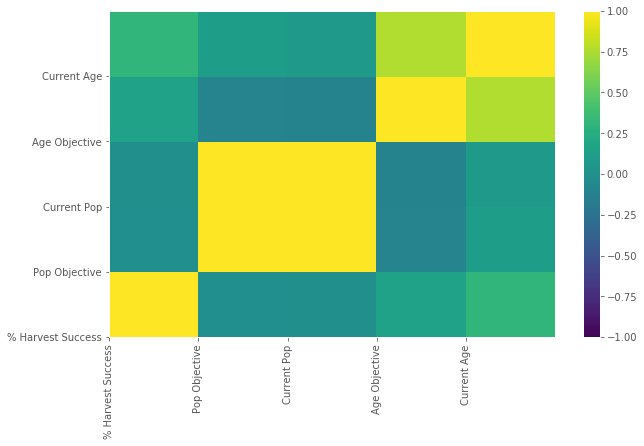

In [30]:
# calculate and visualize correlations as matrix
correlation = check.corr()
print(correlation)

heatmap = plt.pcolor(correlation,vmin=-1,vmax=1)
plt.colorbar(heatmap)
plt.xticks(np.arange(5),('% Harvest Success', 'Pop Objective','Current Pop','Age Objective','Current Age'),rotation='vertical')
plt.yticks(np.arange(5),('% Harvest Success', 'Pop Objective','Current Pop','Age Objective','Current Age'),rotation='horizontal')

In [31]:
# Regression on hunt success

success =  sm.ols(formula="% Hunt Success ~ Pop Objective", data=check).fit()
success.summary()
# Qustion for Kiran: why are we getting this error????

AssertionError: 

### Description of Project Progress

We have acquired most of our data, however during the process we came accross additional data that still needs to be acquired and added to our dataset. We would like to get draw odds of limited entry units, which are only available via pdf right now. We can either manually get data from the pdf, but we are also in the process of contacting the Utah DWR to get the data in a csv form. <br>

Another piece of data that would be nice to acquire is the % of unit that is public land. In the DWR app that we scraped, you can apply filters as map layers that contain public/private land, so this information might be gleanable. 
<br>
If we cannot get this information, then our prject will be a few variables shy of what we proposed.  In that same vein, we haven't figured out a way to get geographical data to show how far each unit is from salt lake city, though we will look into that further as we progress. 

<br>
An important aspect about the dataset is the inclusion of multiple weapon type for each region. Repeats in data are a reflection of this fact and are included in the data set due to the limited permits alloted per weapon type. Once that data is aquired (as mentioned above), the data will become useful. 
<br>
<br>
<br>
Depending if we can get additional data to make our set more robust, we might add the same data we have, but for different species of animals (deer, pronghorn, etc). This will, for the purposes of the project, give us a larger dataset to look at. 
<br>
<br>
Our final analysis will still involve weighting each variable subjectively so we can determine which hunt units are the best. We will also use regression analysis to predic hunter success as well. Another piece that will go into the analysis is we can use the el dataset as a training set, and see if we can predict hunter success in other species (our test sets).  
